In [ ]:
# default_exp background_distributions

In [ ]:
#export
from time import time
class ConditionBackgrounds():

    def __init__(self, normed_condition_df, p2z):
        self.backgrounds = []
        self.ion2background = {}
        self.ion2nonNanvals = {}
        self.idx2ion = {}
        self.init_ion2nonNanvals(normed_condition_df)
        t_start = time()
        self.select_intensity_ranges(p2z)
        t_intensity_selection = time()
        print(f't_intensity_selection {t_intensity_selection - t_start}')


    def init_ion2nonNanvals(self, normed_condition_df):
        t_start = time()
        normed_condition_df['mean'] = normed_condition_df.mean(numeric_only=True, axis=1)
        normed_condition_df = normed_condition_df.sort_values(by='mean').drop('mean', axis=1)
        
        self.normed_condition_df = normed_condition_df
        idx =0
        t_reformat = time()
        nonan_df = normed_condition_df.apply(lambda x :x[x.notna()].to_numpy(), axis=1)
        self.ion2nonNanvals = nonan_df.to_dict()
        t_non_lambda = time()
        for peptide, vals in normed_condition_df.iterrows():
            #self.ion2nonNanvals[peptide] = vals[vals.notna()].values
            self.idx2ion[idx] = peptide
            idx+=1
        t_ion2nonan_assign = time()
        print(f"t_reformat {t_reformat -t_start} t_nonan_lambda {t_non_lambda - t_reformat} t_ion2nonan_assign {t_ion2nonan_assign-t_reformat}")
        

    def select_intensity_ranges(self, p2z):
        total_available_comparisons =0
        num_contexts = 100
        cumulative_counts = np.zeros(self.normed_condition_df.shape[0])

        for idx ,count in enumerate(self.normed_condition_df.count(axis=1)):
            total_available_comparisons+=count-1
            cumulative_counts[idx] = int(total_available_comparisons/2)
        
        
        #assign the context sizes
        context_size = np.max([1000, int(total_available_comparisons/(1+num_contexts/2))])
        halfcontext_size = int(context_size/2)
        context_boundaries = np.zeros(3).astype(int)

        middle_idx = int(np.searchsorted(cumulative_counts, halfcontext_size))
        end_idx = int(np.searchsorted(cumulative_counts, context_size))


        context_boundaries[0] = 0
        context_boundaries[1] = middle_idx
        context_boundaries[2] = end_idx
        while context_boundaries[1] < len(cumulative_counts):
            bgdist = BackGroundDistribution(context_boundaries[0], context_boundaries[2], self.ion2nonNanvals, self.idx2ion, p2z)
            self.assign_ions2bgdists(context_boundaries[0], context_boundaries[2], bgdist)
            self.backgrounds.append(bgdist)
            context_boundaries[0] = context_boundaries[1]
            context_boundaries[1] = context_boundaries[2]
            end_idx = np.searchsorted(cumulative_counts, context_size + cumulative_counts[context_boundaries[0]])
            if end_idx > len(cumulative_counts)-(context_boundaries[1]-context_boundaries[0])/1.5:
                end_idx = len(cumulative_counts)
            context_boundaries[2] = end_idx

    def assign_ions2bgdists(self, boundaries1, boundaries2, bgdist):
        ion2bg_local = {} #dict(map(lambda _idx : (self.normed_condition_df.index.values[_idx], bgdist), range(boundaries1, boundaries2)))
        for idx in range(boundaries1, boundaries2):
            ion2bg_local.update({self.idx2ion.get(idx) : bgdist})
        self.ion2background.update(ion2bg_local)


In [ ]:
#export
import numpy as np
from random import shuffle
import pandas as pd
from scipy.stats import norm
import math
from time import time

class BackGroundDistribution:

    fc_resolution_factor = 100
    fc_conversion_factor = 1/fc_resolution_factor

    def __init__(self, start_idx, end_idx, ion2noNanvals, idx2ion,p2z):
        self.fc2counts = {} #binned Fold change Distribution
        self.cumulative = np.array([])
        self.zscores = np.array([])
        self.min_fc =0
        self.max_fc = 0
        self.min_z=0
        self.max_z=0
        self.start_idx = int(start_idx)
        self.end_idx = int(end_idx)
        self.var = None
        self.SD = None

        anchor_fcs = self.generate_anchorfcs_from_intensity_range(ion2noNanvals, idx2ion)
        shuffle(anchor_fcs)
        self.generate_fc2counts_from_anchor_fcs(anchor_fcs)
        self.cumulative = self.transform_fc2counts_into_cumulative()
        self.calc_SD(0, self.cumulative)
        self.zscores = self.transform_cumulative_into_z_values(p2z)

    def generate_anchorfcs_from_intensity_range(self, ion2noNanvals, idx2ion):
        anchor_fcs = []
        for idx in range(self.start_idx, self.end_idx):
            vals = ion2noNanvals[idx2ion.get(idx)]
            if vals.size < 2:
                continue
            anchor_idx =  np.random.randint(0, len(vals))
            anchor_val = vals[anchor_idx]
            vals = np.delete(vals, anchor_idx)
            anchor_fcs.extend(vals-anchor_val)
        return anchor_fcs


    def generate_fc2counts_from_anchor_fcs(self,anchor_fcs):
        
        anchor_fcs = np.array(anchor_fcs)
        for idx in range(1, anchor_fcs.shape[0]):
            fc_binned = np.rint(self.fc_resolution_factor*(0.5*(anchor_fcs[idx-1] - anchor_fcs[idx]))).astype(np.long)
            self.fc2counts[fc_binned] = self.fc2counts.setdefault(fc_binned, 0) + 1

        self.min_fc = min(self.fc2counts.keys())
        self.max_fc = max(self.fc2counts.keys())

    
    def transform_fc2counts_into_cumulative(self):
        
        cumulative = np.zeros(self.max_fc - self.min_fc +1).astype(np.long)

        for entry in self.fc2counts.items():
            cumulative[int(entry[0]-self.min_fc)] +=entry[1]
        for idx in range(1,cumulative.shape[0]):
            cumulative[idx] +=cumulative[idx-1]
        
        return cumulative

    
    def transform_cumulative_into_z_values(self, p2z):
        total = self.cumulative[-1]
        min_pval = 1/(total+1)
        self.max_z = abs(norm.ppf(max(1e-9, min_pval)))
        zscores = np.zeros(len(self.cumulative))
        zero_pos = -self.min_fc

        normfact_posvals = 1/(total-self.cumulative[zero_pos]+1)
        normfact_negvals = 1/(self.cumulative[zero_pos-1]+1)
        norm_fix = norm()
        for i in range(len(self.cumulative)):
            t_start = time()
            num_more_extreme = 0
            if i == zero_pos:
                zscores[i] = 0
                continue
            if i!=zero_pos and i<len(self.cumulative)-1:
                num_more_extreme = self.cumulative[i] if i<zero_pos else  self.cumulative[-1] - self.cumulative[i+1]
            
            normfact = normfact_negvals if i<zero_pos else normfact_posvals
            p_val = 0.5*max(1e-9, (num_more_extreme+1)*normfact)
            sign = -1 if i<zero_pos else 1
            t_empirical = time()
            zscores[i] = sign*get_z_from_p_empirical(p_val, p2z) ##ppf is the inverese cumulative distribution function
            t_nd_lookup = time()
            #print(f"t_empirical {t_empirical - t_start} t_zcacl {t_nd_lookup - t_empirical}")
        return zscores


    def calc_zscore_from_fc(self, fc):
        if abs(fc)<1e-9:
            return 0
        k = int(fc * self.fc_resolution_factor)
        rank = k-self.min_fc
        if rank <0:
            return -self.max_z
        if rank >=len(self.cumulative):
            return self.max_z
        return self.zscores[rank]


    def calc_SD(self, mean, cumulative):
        sq_err = 0.0
        previous =0
        for i in range(len(cumulative)):
            fc = (i+self.min_fc)*self.fc_conversion_factor
            sq_err += (cumulative[i] - previous)*(fc-mean)**2
            previous = cumulative[i]
        total = cumulative[-1]
        var = sq_err/total
        self.var = var
        self.SD = math.sqrt(var)



In [ ]:
#export
from scipy.stats import norm
from numba import jit
from time import time

class SubtractedBackgrounds(BackGroundDistribution):

    def __init__(self, from_dist, to_dist, p2z):
        self.max_fc = None
        self.min_fc = None
        self.var_from = from_dist.var
        self.var_to = to_dist.var
        self.cumulative = None
        max_joined, min_joined, cumulative = subtract_distribs(from_dist, to_dist)
        self.max_fc = max_joined
        self.min_fc = min_joined
        self.cumulative = cumulative
        t_start = time()
        self.fc2counts = transform_cumulative_into_fc2count(self.cumulative,self.min_fc)
        t_cumul_transf = time()
        self.calc_SD(0, self.cumulative)
        t_calc_SD = time()
        self.zscores = self.transform_cumulative_into_z_values(p2z)
        t_calc_zvals = time()
        #print(f"t_cumul {t_cumul_transf-t_start} t_SD {t_calc_SD-t_cumul_transf} t_zval {t_calc_zvals - t_calc_SD}")
        
def subtract_distribs(from_dist, to_dist):
    min_joined = from_dist.min_fc - to_dist.max_fc
    max_joined = from_dist.max_fc - to_dist.min_fc

    n_from = get_normed_freqs(from_dist.cumulative)
    n_to = get_normed_freqs(to_dist.cumulative)

    min_from = from_dist.min_fc
    min_to = to_dist.min_fc

    joined_init = np.zeros(max_joined-min_joined+1, dtype="long")
    t_start = time()
    joined = get_joined(joined_init, n_from,n_to, min_from, min_to, min_joined)
    t_join = time()
    cumulative = get_cumul_from_freq(joined)
    t_cumul = time()
    
    return max_joined, min_joined, cumulative

@jit(nopython=True)
def get_joined(joined,n_from, n_to, min_from, min_to, min_joined):
    count_comparisons =0
    for from_idx in range(len(n_from)):
        fc_from = min_from + from_idx
        freq_from = n_from[from_idx]
        for to_idx in range(len(n_to)):
            fc_to = min_to + to_idx
            freq_to = n_to[to_idx]
            fcdiff = fc_from - fc_to
            joined_idx = fcdiff - min_joined
            freq_multiplied = freq_from*freq_to
            joined[joined_idx] += (freq_multiplied)
            count_comparisons+=1
    return joined

In [ ]:
#hide

def test_subtract_distribs():
    from_dist = [1,1,2,1,1]
    to_dist = [1,1,2,1,1]

In [ ]:
#export
def get_subtracted_bg(ion2diffDist, condbg1, condbg2, ion, p2z):
    if ion in ion2diffDist.keys():
        return ion2diffDist.get(ion)
    bg1 = condbg1.ion2background.get(ion)
    bg2 = condbg2.ion2background.get(ion)
    ions_bg1 = set(map(lambda _idx : condbg1.idx2ion.get(_idx), range(bg1.start_idx, bg1.end_idx)))
    ions_bg2 = set(map(lambda _idx : condbg2.idx2ion.get(_idx), range(bg2.start_idx, bg2.end_idx)))
    common_ions = ions_bg1.intersection(ions_bg2)
    subtr_bg = SubtractedBackgrounds(bg1, bg2, p2z)
    for intersect_ion in common_ions:
        ion2diffDist.update({intersect_ion : subtr_bg})
    return subtr_bg

In [ ]:
#export
from scipy.stats import norm

def get_z_from_p_empirical(p_emp,p2z):
    p_rounded = np.format_float_scientific(p_emp, 1)
    if p_rounded in p2z:
        return p2z.get(p_rounded)
    z = norm.ppf(float(p_rounded))
    p2z[p_rounded] = z
    return z

In [ ]:
#export
#get normalized freqs from cumulative

def get_normed_freqs(cumulative):
    normfact = 1e5 /cumulative[-1]
    freqs =get_freq_from_cumul(cumulative)
    for i in range(len(freqs)):
        freqs[i] *= normfact
    return freqs



In [ ]:
#export
#transform cumulative into frequency

def get_freq_from_cumul(cumulative):
    res = np.zeros(len(cumulative), dtype="long")
    res[0] = cumulative[0]
    for i in range(1,len(cumulative)):
        res[i] = cumulative[i]-cumulative[i-1]

    return res


In [ ]:
#export
def transform_cumulative_into_fc2count(cumulative, min_fc):
    res = {}
    for idx in range(1, len(cumulative)):
        fc = idx + min_fc
        res[fc] = cumulative[idx] - cumulative[idx-1]
    return res


In [ ]:
#export
def get_cumul_from_freq(freq):
    res = np.zeros(len(freq), dtype="long")
    res[0] = freq[0]
    for i in range(1,len(freq)):
        res[i] = res[i-1] + freq[i]

    return res


In [ ]:
def generate_random_input(num_pep,sample2cond_df ):
    pepnames = list(map(lambda _idx : str(uuid.uuid4()), range(num_pep))) #gives uuid strings for each peptide
    randarrays = 10+ 1.5*np.random.randn(num_pep,sample2cond_df.shape[0])
    df_intens = pd.DataFrame(randarrays, columns= sample2cond_df["sample"].tolist())
    df_intens.insert(0, "peptides", pepnames )
    df_intens = df_intens.set_index("peptides")
    return df_intens

sample2cond_df = pd.DataFrame({'sample' : ['A1', 'A2', 'A3', 'B1', 'B2', 'B3'], 'condition' : ['A', 'A', 'A', 'B', 'B', 'B']})
fixed_input = generate_random_input(1000, sample2cond_df)

In [ ]:
#hide
import pandas as pd
import numpy as np
import uuid


def test_condition_backgrounds(unnormed_df):
    condbg = ConditionBackgrounds(unnormed_df)
    nonbg_ions = list(set(condbg.ion2nonNanvals.keys()).difference(condbg.ion2background.keys()))
    display(condbg.normed_condition_df)
    
    assert condbg.ion2background.keys() == condbg.ion2nonNanvals.keys()


test_condition_backgrounds(fixed_input)


,A1,A2,A3,B1,B2,B3
peptides,,,,,,
bd9909c5-fd30-4dd7-b5e7-fbbfbd473f2f,12.022295,6.628220,9.139041,8.570409,5.540129,7.595941
73ecdaaa-0573-422d-a52a-398b9802ab2e,11.904403,8.445404,7.802941,9.595333,6.826428,6.304770
8ba42d76-806e-4a35-b6ef-61a6a21eddce,7.955249,8.490428,7.575383,8.804983,10.413489,7.686398
135899e5-4e7e-4478-b906-4506f560a676,6.502068,8.784694,9.509414,8.899448,8.678971,8.658776
366febc4-93c0-4973-8824-9532b06308c1,6.807153,8.340483,7.477828,7.386518,13.106652,7.933880
...,...,...,...,...,...,...
20623aa8-5edf-4500-874a-516de8e92d04,12.138152,12.015938,10.513137,10.927449,11.532933,12.329544
3dd894c1-b3a7-4c40-aa50-91b3c56296b1,11.537934,12.198880,11.098274,12.282254,10.931920,11.849975
d9c7e6f6-0d5f-4838-b9c2-f77d84babf79,12.845147,10.336424,10.392113,12.283825,11.995161,12.445587


In [ ]:
#hide
#test subtract background distribution
from scipy.stats import norm
import matplotlib.pyplot as plt

idx2nonnanvals = {}

for idx in range(2000):
    nonnanvals =  np.random.normal(loc=0, size=3)
    idx2nonnanvals[idx] = nonnanvals
    
bgdist1 = BackGroundDistribution(0, 999, idx2nonnanvals)
bgdist2 = BackGroundDistribution(1000, 1999, idx2nonnanvals)

freqdist = get_normed_freqs(bgdist1.cumulative)
plt.bar(range(len(freqdist)),freqdist,width=1,color='g')
plt.show()

subtracted_bgs = SubtractedBackgrounds(bgdist1, bgdist2)

def tranform_fc2count_to_fc_space(fc2counts, num_fcs, rescale_factor):
    fc2counts_fcscales = {}
    for fc, count in fc2counts.items():
        fc2counts_fcscales[fc*rescale_factor] = count/num_fcs

    return fc2counts_fcscales

fc2counts_rescaled = tranform_fc2count_to_fc_space(subtracted_bgs.fc2counts, subtracted_bgs.cumulative[-1],1/100.0)

plt.bar(list(fc2counts_rescaled.keys()), fc2counts_rescaled.values(),width=0.01,color='g')
axes2 = plt.twinx()
x = np.linspace(-4, 4, 1000)
axes2.plot(x, norm.pdf(x, 0, subtracted_bgs.SD)*1.3, color = "red")
axes2.set_ylim(0.0, 0.4)
plt.show()



TypeError: __init__() missing 1 required positional argument: 'idx2ion'

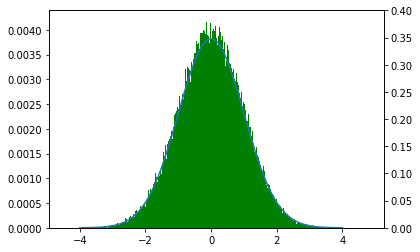

In [ ]:
#hide
#test background distribution
from scipy.stats import norm
import matplotlib.pyplot as plt

idx2nonnanvals = {}
idx2ion = {}
for idx in range(100000):
    nonnanvals =  np.random.normal(loc=0, size=3)
    idx2nonnanvals[idx] = nonnanvals
    idx2ion[idx] = idx
    
bgdist = BackGroundDistribution(0, 99999, idx2nonnanvals, idx2ion)

def tranform_fc2count_to_fc_space(fc2counts, num_fcs, rescale_factor):
    fc2counts_fcscales = {}
    for fc, count in fc2counts.items():
        fc2counts_fcscales[fc*rescale_factor] = count/num_fcs

    return fc2counts_fcscales

fc2counts_rescaled = tranform_fc2count_to_fc_space(bgdist.fc2counts, bgdist.cumulative[-1],1/100.0)

plt.bar(list(fc2counts_rescaled.keys()), fc2counts_rescaled.values(),width=0.01,color='g',)
axes2 = plt.twinx()
x = np.linspace(-4, 4, 1000)
axes2.plot(x, norm.pdf(x, 0, bgdist.SD)/1.15)
axes2.set_ylim(0.0, 0.4)
plt.show()






In [ ]:
import numpy as np
display(np.min([1,2]))

1